In [1]:
!pip install kagglehub scikit-learn matplotlib seaborn

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.calibration import calibration_curve
import pandas as pd

In [3]:
# Mount Google Drive to load the saved model weights
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
base_dir = os.path.join(dataset_path, "Dataset")

# Create dataset function (same as your original)
AUTOTUNE = tf.data.AUTOTUNE

def augment_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Here, you can include augmentation if desired.
    image = preprocess_input(image)
    return tf.cast(image, tf.float32), label

def create_dataset(directory, augment=False):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=(256, 256),
        batch_size=None,
        shuffle=augment,
        seed=42 if augment else None
    )
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(64).prefetch(AUTOTUNE)

# Load test dataset
test_ds = create_dataset(os.path.join(base_dir, "Test"), augment=False)

Found 10905 files belonging to 2 classes.


In [5]:
# Load the saved Keras model (saved using ModelCheckpoint)
model = tf.keras.models.load_model("/content/drive/MyDrive/ML Project/New Folder/resnet50_8386.keras")
print("Model loaded successfully.")

Model loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 442 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# Evaluate the model on the test set using model.evaluate
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

171/171 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - accuracy: 0.9338 - auc: 0.4718 - loss: 0.2856
Test Loss: 0.8210
Test Accuracy: 0.8385
Test AUC: 0.9048


In [7]:
# Get predictions and corresponding labels from the test set
all_preds = []
all_labels = []
for images, labels in test_ds:
    preds = model(images, training=False)
    # Since the final activation is sigmoid, predictions are in [0, 1]
    all_preds.extend(preds.numpy().flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

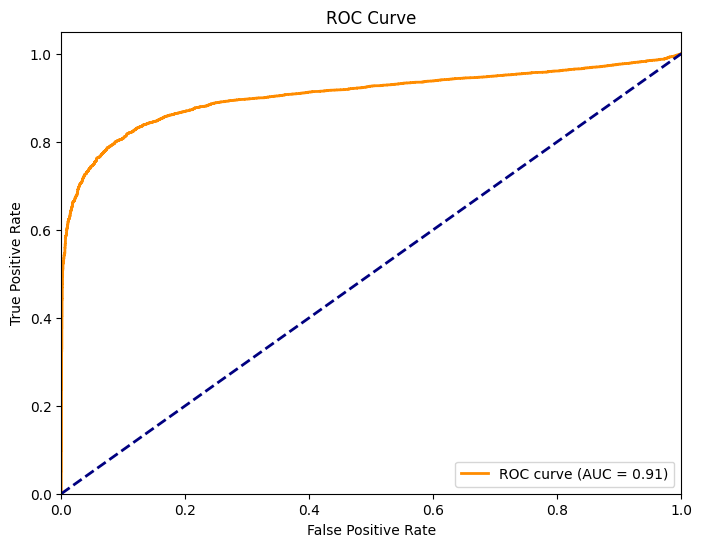

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

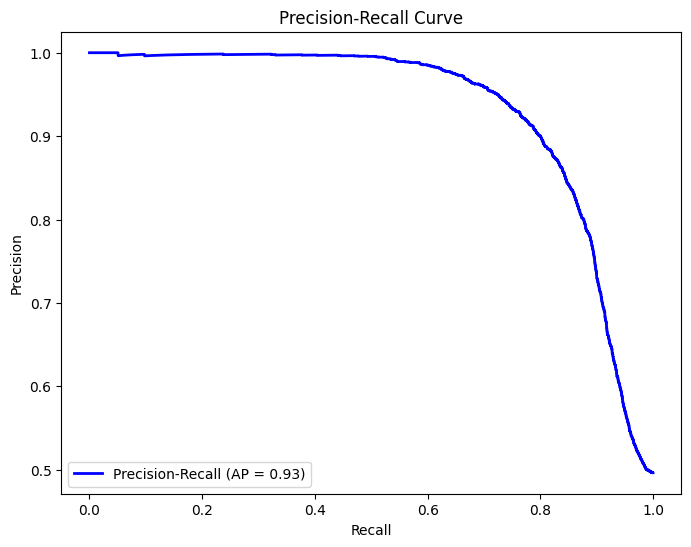

In [9]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
average_precision = average_precision_score(all_labels, all_preds)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

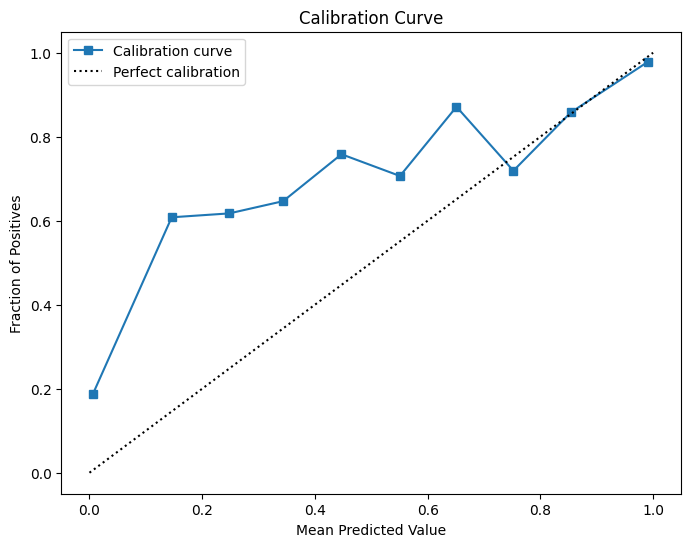

In [10]:
# Calibration Curve (Reliability Diagram)
fraction_of_positives, mean_predicted_value = calibration_curve(all_labels, all_preds, n_bins=10, strategy='uniform')

plt.figure(figsize=(8,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibration curve')
plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.show()

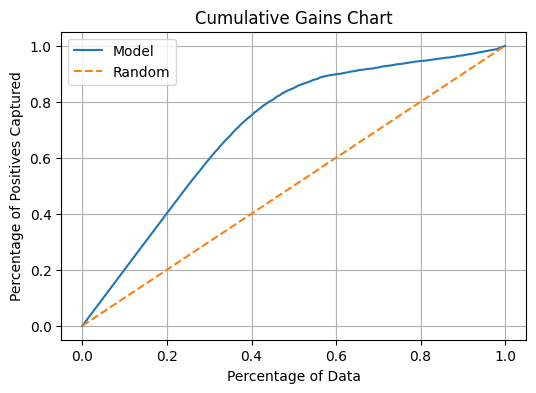

In [11]:
# Cumulative Gains Chart
df = pd.DataFrame({"label": all_labels, "pred": all_preds})
df = df.sort_values("pred", ascending=False).reset_index(drop=True)
df["cumulative_positive"] = df["label"].cumsum()
df["percentage_positive"] = df["cumulative_positive"] / df["label"].sum()
df["percentage_data"] = (df.index + 1) / len(df)

plt.figure(figsize=(6, 4))
plt.plot(df["percentage_data"], df["percentage_positive"], label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("Percentage of Data")
plt.ylabel("Percentage of Positives Captured")
plt.title("Cumulative Gains Chart")
plt.legend()
plt.grid(True)
plt.show()

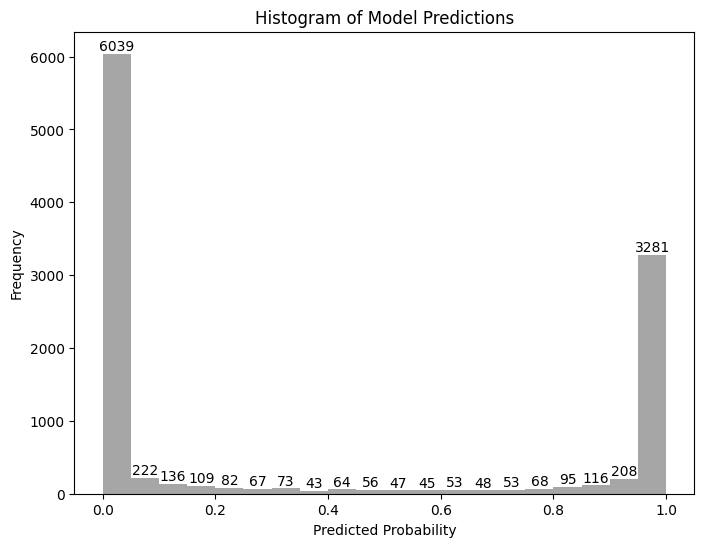

In [12]:
plt.figure(figsize=(8,6))
# Create histogram with 20 bins
counts, bins, patches = plt.hist(all_preds, bins=20, color='gray', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Model Predictions')

# Annotate each bin with its count
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, f'{int(count)}',
             ha='center', va='bottom', fontsize=10)

plt.show()


Threshold: 0.3
Test Accuracy: 0.8475


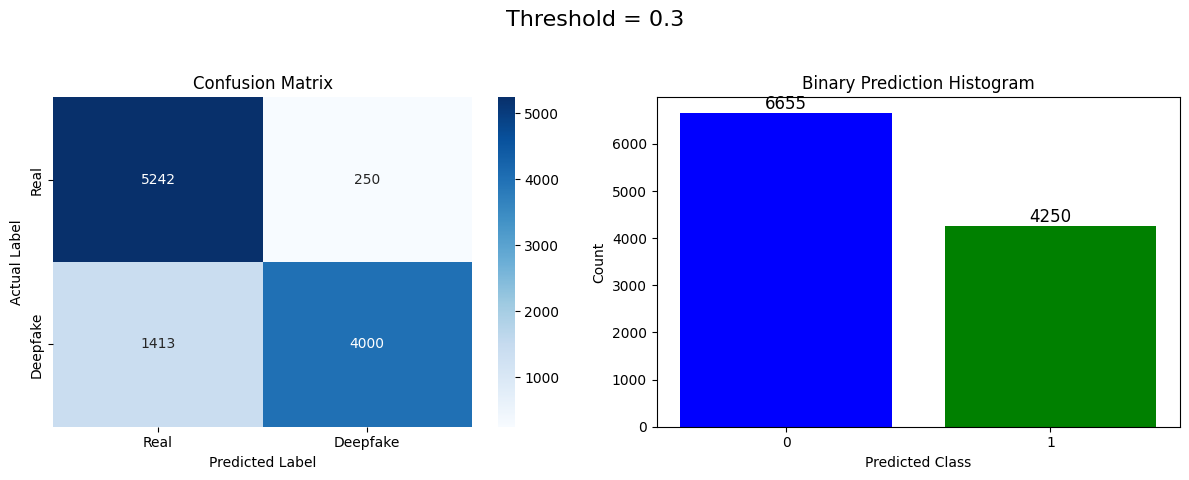


Threshold: 0.4
Test Accuracy: 0.8444


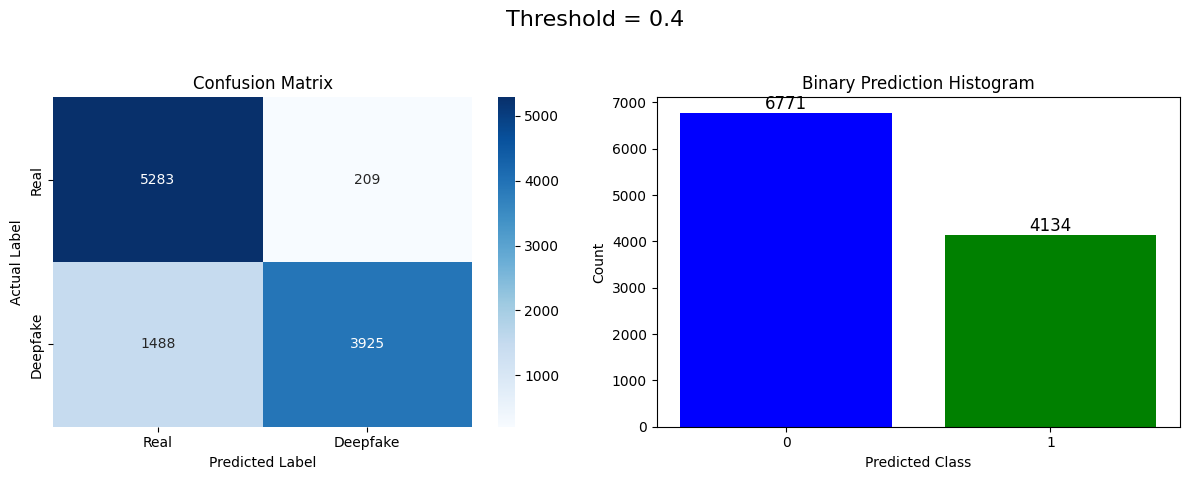


Threshold: 0.5
Test Accuracy: 0.8387


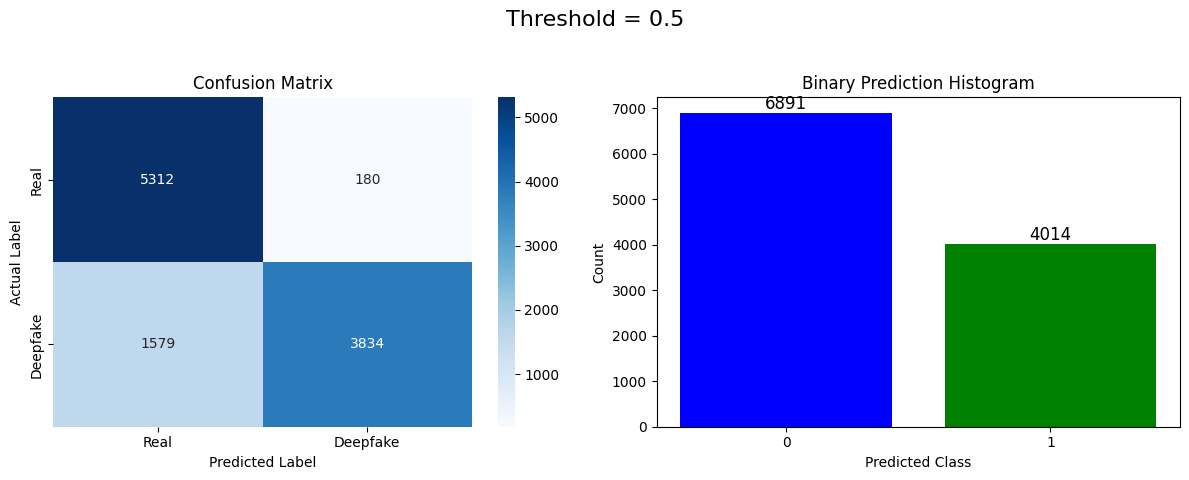


Threshold: 0.6
Test Accuracy: 0.8352


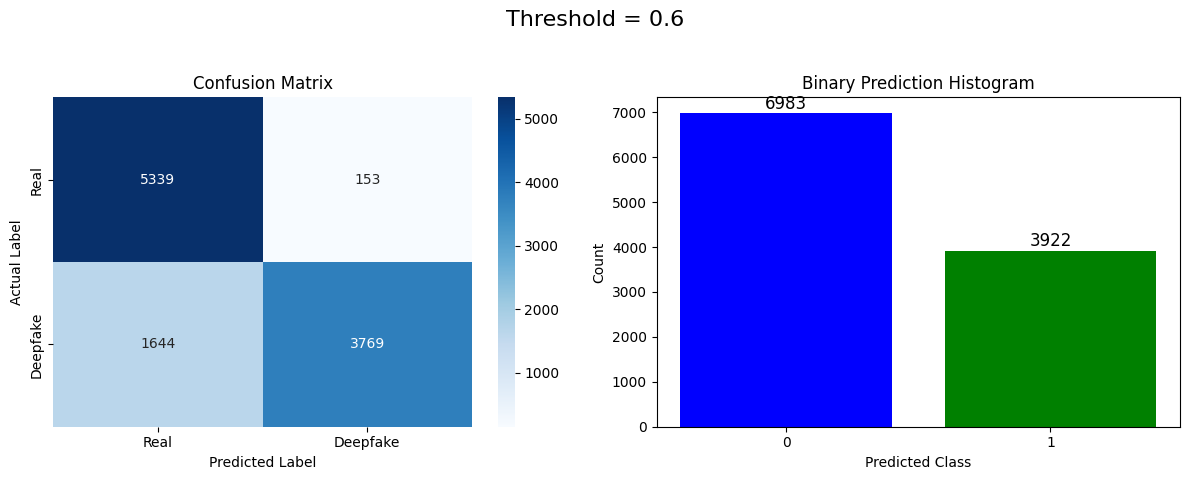


Threshold: 0.7
Test Accuracy: 0.8283


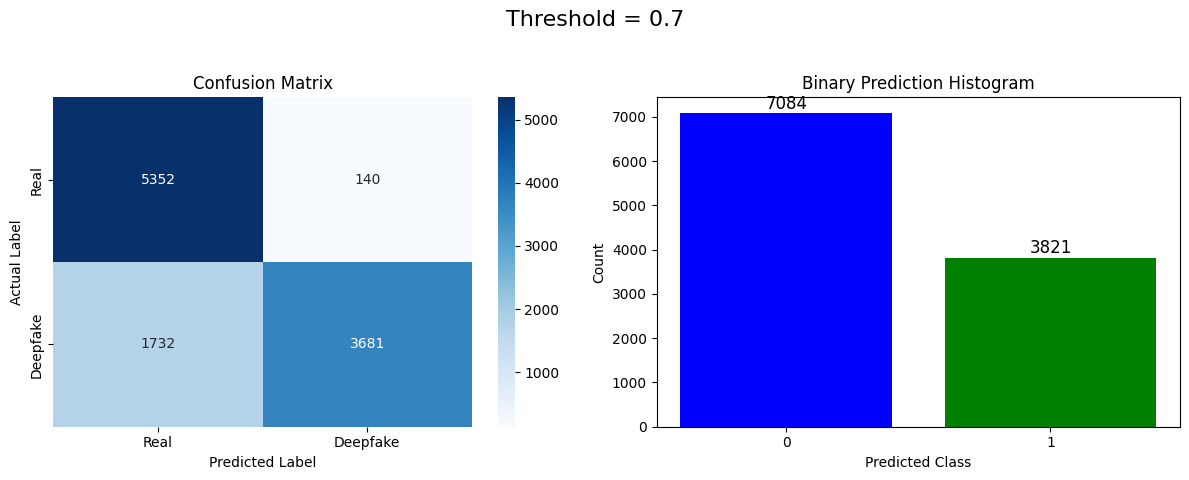

In [13]:
# Analysis for different probability thresholds (without histogram)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    test_preds_labels = (np.array(all_preds) >= thresh).astype(int)
    test_labels_np = np.array(all_labels).astype(int)
    test_accuracy = (test_preds_labels == test_labels_np).mean()

    print(f"\nThreshold: {thresh}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Create a figure with 1 row and 2 columns for organized plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Threshold = {thresh}", fontsize=16)

    # Confusion Matrix Heatmap
    cm = confusion_matrix(test_labels_np, test_preds_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Deepfake'], yticklabels=['Real', 'Deepfake'], ax=axs[0])
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('Actual Label')
    axs[0].set_title('Confusion Matrix')

    # Bar Chart of Binary Predictions
    unique, counts = np.unique(test_preds_labels, return_counts=True)
    axs[1].bar(unique, counts, color=['blue', 'green'])
    axs[1].set_xticks([0, 1])
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Binary Prediction Histogram')
    for i, count in zip(unique, counts):
        axs[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()